Epoch 0/5, Step 0/374, LossD: 1.4581377506256104, LossG: 2.8645734786987305
Epoch 0/5, Step 100/374, LossD: 0.006381976883858442, LossG: 8.943058013916016
Epoch 0/5, Step 200/374, LossD: 0.9083397388458252, LossG: 2.501619338989258
Epoch 0/5, Step 300/374, LossD: 0.42353418469429016, LossG: 3.3878228664398193
Saved generated images for epoch 0 at D:\Akash\Work\AI\GAN\v360_gan\synthetic_images_epoch_0.png
Epoch 1/5, Step 0/374, LossD: 0.29411235451698303, LossG: 3.1262784004211426
Epoch 1/5, Step 100/374, LossD: 0.20570862293243408, LossG: 4.65116548538208
Epoch 1/5, Step 200/374, LossD: 0.13064567744731903, LossG: 5.247413635253906
Epoch 1/5, Step 300/374, LossD: 0.28337541222572327, LossG: 4.256024360656738
Saved generated images for epoch 1 at D:\Akash\Work\AI\GAN\v360_gan\synthetic_images_epoch_1.png
Epoch 2/5, Step 0/374, LossD: 0.15382926166057587, LossG: 3.3746626377105713
Epoch 2/5, Step 100/374, LossD: 0.1398342251777649, LossG: 4.604489326477051
Epoch 2/5, Step 200/374, LossD:

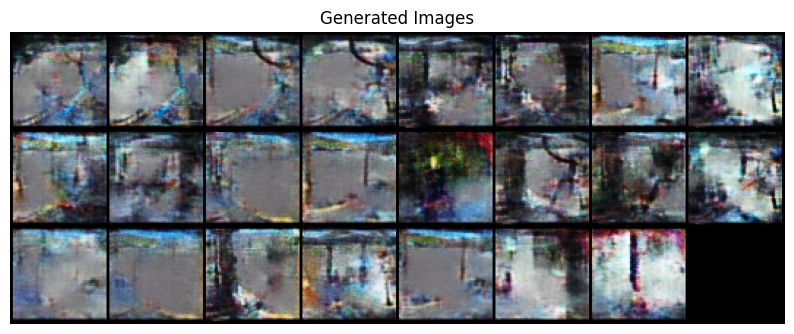

In [6]:
import os
import torch
import torch.nn as nn
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Paths and hyperparameters
image_folder_path = r"D:\Akash\Work\AI\Datasets\test_data\v360_test_data\images"  # Path to YOLO 'image' folder
output_dir = r"D:\Akash\Work\AI\GAN\v360_gan"
os.makedirs(output_dir, exist_ok=True)

image_size = 64          # Size to resize images for GAN input
batch_size = 64
num_epochs = 5           # Increase as needed
nz = 100                 # Size of generator input (latent vector)
lr = 0.0002              # Learning rate for both Generator and Discriminator
beta1 = 0.5              # Beta1 hyperparam for Adam optimizers

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Custom Dataset class for YOLO images only
class YOLOImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) 
                            if fname.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Load dataset and create DataLoader
yolo_image_dataset = YOLOImageDataset(root_dir=image_folder_path, transform=transform)
dataloader = DataLoader(yolo_image_dataset, batch_size=batch_size, shuffle=True)

# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Initialize models, criterion, and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator().to(device)
netD = Discriminator().to(device)
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training loop
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator
        netD.zero_grad()
        real_data = data.to(device)
        batch_size = real_data.size(0)
        label = torch.full((batch_size,), 1., device=device)
        
        output = netD(real_data).view(-1)
        lossD_real = criterion(output, label)
        lossD_real.backward()
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_data = netG(noise)
        label.fill_(0.)
        
        output = netD(fake_data.detach()).view(-1)
        lossD_fake = criterion(output, label)
        lossD_fake.backward()
        
        optimizerD.step()
        
        # Update Generator
        netG.zero_grad()
        label.fill_(1.)
        
        output = netD(fake_data).view(-1)
        lossG = criterion(output, label)
        lossG.backward()
        
        optimizerG.step()
        
        if i % 100 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Step {i}/{len(dataloader)}, LossD: {lossD_real+lossD_fake}, LossG: {lossG}')
    
    # Save generated images at the end of each epoch
    with torch.no_grad():
        fake_data = netG(noise).detach().cpu()
    image_path = os.path.join(output_dir, f'synthetic_images_epoch_{epoch}.png')
    vutils.save_image(fake_data, image_path, normalize=True)
    print(f"Saved generated images for epoch {epoch} at {image_path}")

# Display the last batch of generated images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_data, padding=2, normalize=True), (1, 2, 0)))
plt.show()
